In [1]:
from ANEMO import ANEMO
from ANEMO import read_edf
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters


In [2]:
datafile = 'data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

expfile = 'data/enregistrement_AM_2017-10-23_100057.pkl'
with open(expfile, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

In [3]:
A = ANEMO(exp)
Fit = ANEMO.Fit(exp)
Plot = ANEMO.Plot(exp)

In [4]:
def figure(N_trial=1, N_block=1, plot='') :

    nb_trial = N_trial*N_block
    
    if plot=='scatter' :
        fig, axs = plt.subplots(1, 3, figsize=(5*3, 5/1.6180))

    else :
        
        fig, axs = plt.subplots(nb_trial, 1, figsize=(15, nb_trial*(15*1/2)/1.6180))
    
    
    for block in range(N_block) :
        
        for trial in range(N_trial) :
            
            arg = A.arg(data[trial+block*N_trial], trial=trial, block=block)
            
            velocity_NAN = A.velocity_NAN(**arg)[0]
            old = {}
            old['latence'], old['maxi'], old['v_anti'] = ANEMO.classical_method.Full(velocity_NAN, arg.TargetOn-arg.t_0)
            f = Fit.Fit_trial(velocity_NAN, equation='fct_velocity',value_latence=old['latence'],
                              value_maxi=old['maxi'], value_anti=old['v_anti'], **arg)
            
            fit = ANEMO.Equation.fct_velocity(np.arange(len(velocity_NAN)), arg.dir_target,
                                                  f.values['start_anti'], f.values['v_anti'],
                                                  f.values['latence'], f.values['tau'],
                                                  f.values['maxi'], do_whitening=False)
            
            steady_state = f.values['maxi']*arg.dir_target + fit[int(f.values['latence'])]
            
            if plot=='scatter' :
                
                for x, var in enumerate(['latence', 'v_anti']) :
                    axs[x].set_title(var)
                    axs[x].scatter(old[var], f.values[var], c='k', alpha=0.5)
                
                axs[2].set_title('steady_state')
                axs[2].scatter(old['maxi'], steady_state*arg.dir_target, c='k', alpha=0.5)
                
                for x in range(3) :
                    axs[x].set_xlabel('old')
                    axs[x].set_ylabel('fit')


            else :
                if nb_trial==1 : ax = axs
                else : ax = axs[trial]
                
                debut = arg.TargetOn-arg.t_0
                trackertime_s = arg.trackertime - arg.TargetOn
                
                ax.plot(trackertime_s, velocity_NAN, c='k', alpha=0.5)
                ax.plot(trackertime_s, fit, c='k')

                ax.bar(f.values['latence']-debut, 60, bottom=-30, color='k', width=4)
                ax.plot(trackertime_s, np.ones(len(velocity_NAN))*steady_state, c='k')

                ax.bar(old['latence']-debut, 60, bottom=-30, color='r', width=4)
                ax.plot(trackertime_s, np.ones(len(velocity_NAN))*old['maxi']*(arg.dir_target), c='r')
                
                ax.plot(np.arange(-50,50), range(100)*(old['v_anti']/1000), c='r', lw=2)
                ax = Plot.deco(ax, t_label=10, **arg)
                ax.set_ylabel('Velocity (°/s)', fontsize=10)
                ax.set_title('block %s, trial %s'%(block, trial))
            plt.tight_layout() 

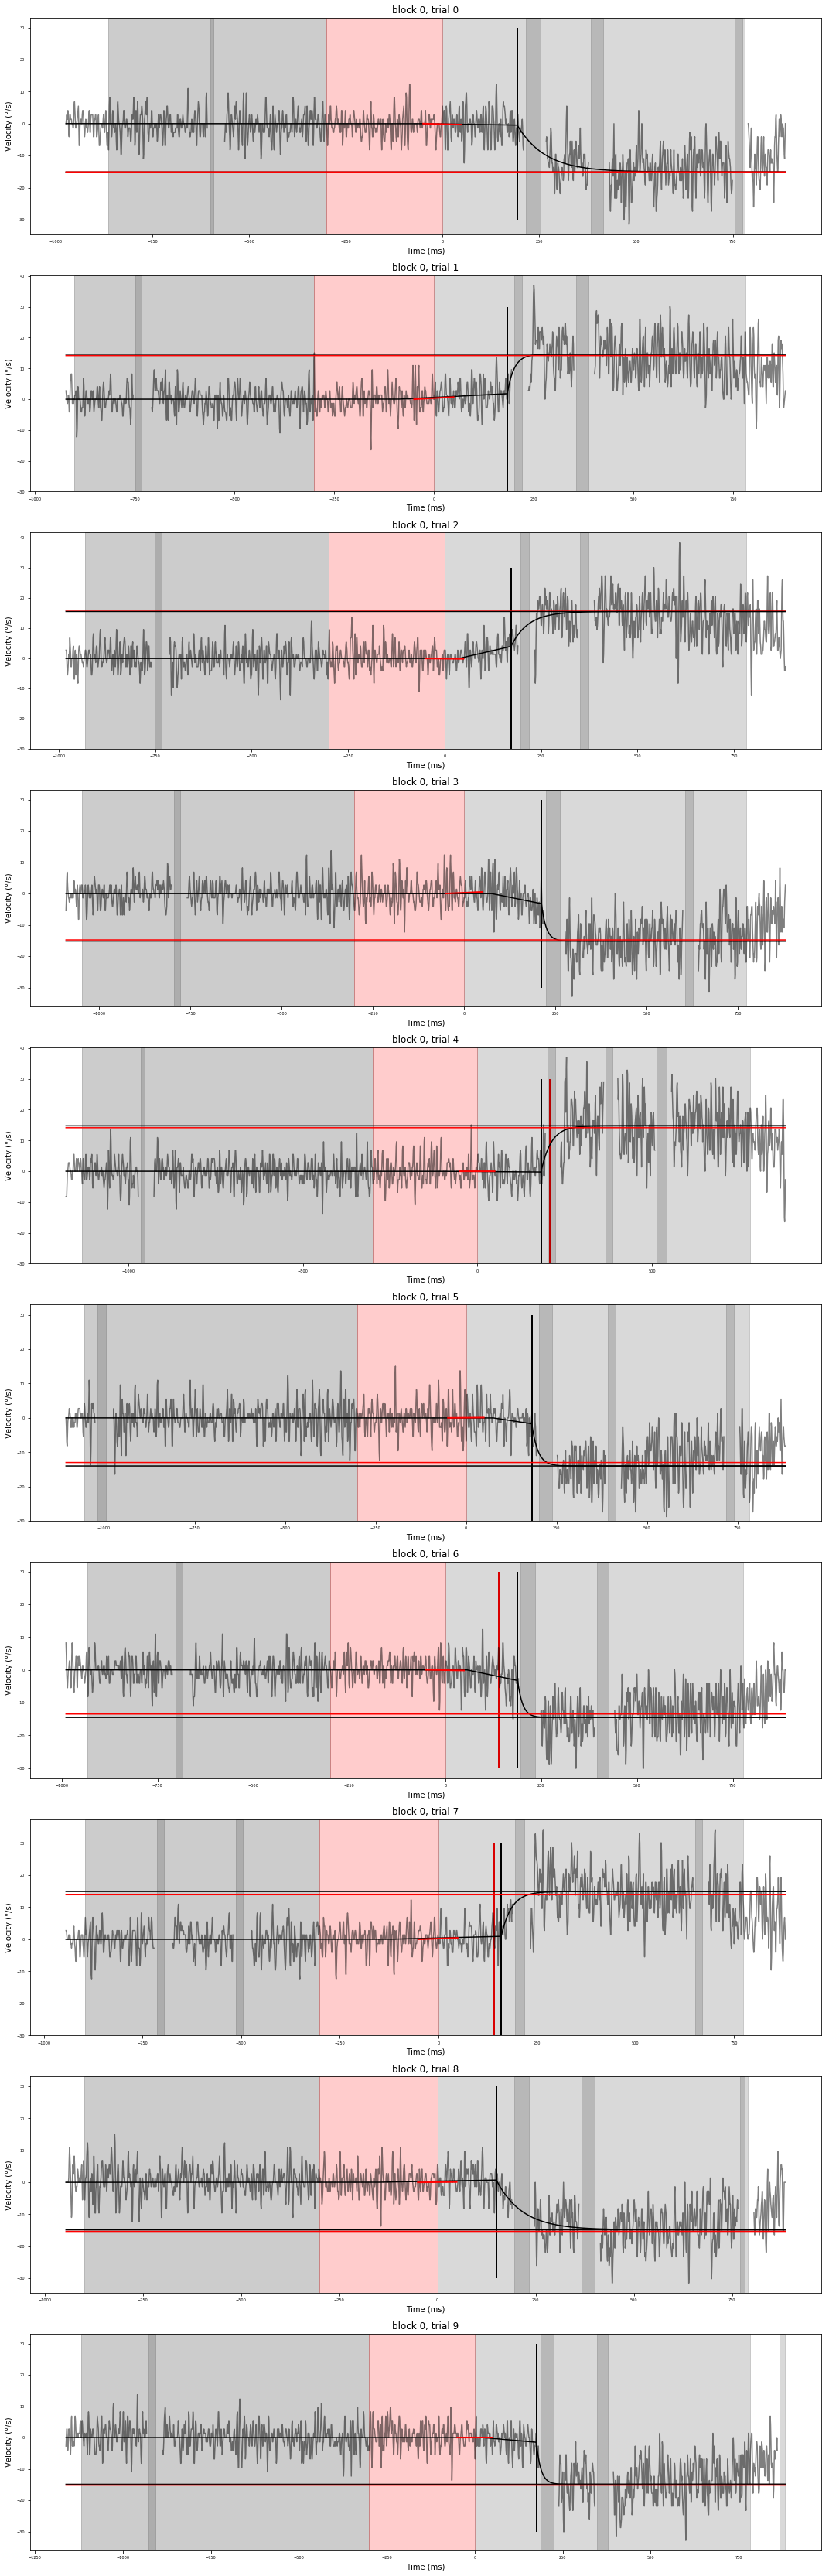

In [5]:
figure(N_trial=10)

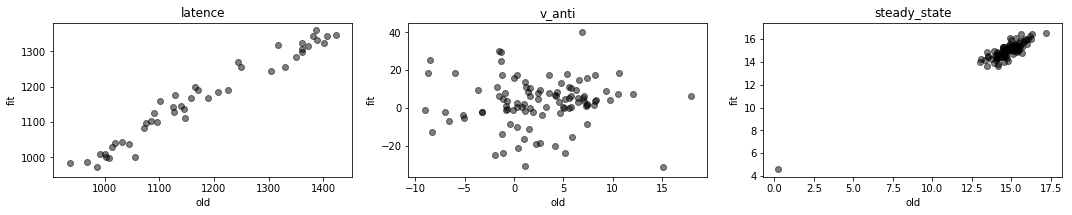

In [6]:
figure(N_trial=100, plot='scatter')